In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import torch.nn.functional as F


In [2]:
torch.manual_seed(42)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)


cuda


In [3]:
"""
    A Convolutional Neural Network (CNN) model designed for image classification tasks, 
    such as CIFAR-10, with input images of size 32x32 and 3 color channels (RGB).
    
    The model consists of:
    - Convolutional Layers: Three convolutional layers with Batch Normalization and ReLU activation.
      The number of filters increases progressively, starting from `num_filters` and doubling at each layer.
    - Pooling Layers: MaxPooling is applied after each convolutional layer to reduce spatial dimensions.
    - Dropout: Applied after fully connected layers to prevent overfitting.
    - Fully Connected Layers: Three fully connected layers to map the extracted features to the final 
      10 output classes.

    The model architecture is as follows:
    - Conv Layer 1: 3 input channels, `num_filters` output channels, 3x3 kernel, followed by BatchNorm and ReLU.
    - Conv Layer 2: `num_filters` input channels, `num_filters * 2` output channels, 3x3 kernel, followed by BatchNorm and ReLU.
    - Conv Layer 3: `num_filters * 2` input channels, `num_filters * 4` output channels, 3x3 kernel, followed by BatchNorm and ReLU.
    - MaxPooling: Applied after each convolutional block to reduce the spatial dimensions by a factor of 2.
    - Dropout: Dropout with 50% probability is applied before each fully connected layer.
    - Fully Connected Layer 1: Maps flattened feature vector to 512 units with ReLU activation.
    - Fully Connected Layer 2: Maps 512 units to 256 units with ReLU activation.
    - Fully Connected Layer 3: Final layer mapping 256 units to 10 output classes for classification.
"""

class CNNModel(nn.Module):
    def __init__(self, num_filters):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, num_filters, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(num_filters)
        self.conv2 = nn.Conv2d(num_filters, num_filters * 2, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(num_filters * 2)
        self.conv3 = nn.Conv2d(num_filters * 2, num_filters * 4, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(num_filters * 4)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        
        # Compute output size after conv layers
        self._to_linear = None
        self._get_conv_output_size()
        
        self.fc1 = nn.Linear(self._to_linear, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
    
    def _get_conv_output_size(self):
        with torch.no_grad():
            x = torch.randn(1, 3, 32, 32)  # CIFAR-10 input size (1, 3, 32, 32)
            x = self.pool(F.relu(self.bn1(self.conv1(x))))
            x = self.pool(F.relu(self.bn2(self.conv2(x))))
            x = self.pool(F.relu(self.bn3(self.conv3(x))))
            self._to_linear = x.view(1, -1).size(1)
    
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x


In [4]:
learning_rate = 0.0001
num_epochs = 15
batch_size = 64

# Update data augmentation for better generalization
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
#Training, Testing, and Evaluating the model.

def train_and_evaluate_model(num_filters, model_count):
    model = CNNModel(num_filters).cuda()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    train_losses, test_losses = [], []
    train_accs, test_accs = [], []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        for data, target in tqdm(train_loader):
            data, target = data.cuda(), target.cuda()
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
        
        train_acc = 100 * correct / total
        train_losses.append(train_loss / len(train_loader))
        train_accs.append(train_acc)
        
        model.eval()
        test_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.cuda(), target.cuda()
                output = model(data)
                loss = criterion(output, target)
                test_loss += loss.item()
                _, predicted = torch.max(output.data, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()

        test_acc = 100 * correct / total
        test_losses.append(test_loss / len(test_loader))
        test_accs.append(test_acc)

        # Print statement for each epoch
        print(f'Model - {model_count} :: Epoch - {epoch + 1} Train Loss - {train_loss:.6f} Test Loss - {test_loss:.6f} Train Accuracy - {train_acc:.6f} Test Accuracy - {test_acc:.6f}')

    return train_losses, test_losses, train_accs, test_accs

In [6]:
num_filters_list = random.sample(range(16, 64), 10)

all_train_losses = []
all_test_losses = []
all_train_accs = []
all_test_accs = []
num_params = []

for i, num_filters in enumerate(num_filters_list, 1):
    train_losses, test_losses, train_accs, test_accs = train_and_evaluate_model(num_filters, i)
    all_train_losses.append(train_losses[-1])
    all_test_losses.append(test_losses[-1])
    all_train_accs.append(train_accs[-1])
    all_test_accs.append(test_accs[-1])
    
    # Count number of parameters
    model = CNNModel(num_filters)
    num_params.append(sum(p.numel() for p in model.parameters()))

100%|██████████| 782/782 [00:10<00:00, 74.77it/s] 


Model - 1 :: Epoch - 1 Train Loss - 1340.138663 Test Loss - 217.086226 Train Accuracy - 35.872000 Test Accuracy - 49.660000


100%|██████████| 782/782 [00:08<00:00, 87.48it/s] 


Model - 1 :: Epoch - 2 Train Loss - 1049.116060 Test Loss - 178.492353 Train Accuracy - 51.040000 Test Accuracy - 58.580000


100%|██████████| 782/782 [00:08<00:00, 86.94it/s]


Model - 1 :: Epoch - 3 Train Loss - 922.945396 Test Loss - 166.610472 Train Accuracy - 57.954000 Test Accuracy - 62.340000


100%|██████████| 782/782 [00:08<00:00, 93.48it/s] 


Model - 1 :: Epoch - 4 Train Loss - 850.798087 Test Loss - 154.330298 Train Accuracy - 61.418000 Test Accuracy - 65.380000


100%|██████████| 782/782 [00:09<00:00, 86.89it/s]


Model - 1 :: Epoch - 5 Train Loss - 799.561815 Test Loss - 143.679186 Train Accuracy - 63.936000 Test Accuracy - 67.810000


100%|██████████| 782/782 [00:08<00:00, 87.52it/s]


Model - 1 :: Epoch - 6 Train Loss - 762.489832 Test Loss - 142.921605 Train Accuracy - 65.714000 Test Accuracy - 67.760000


100%|██████████| 782/782 [00:08<00:00, 88.21it/s] 


Model - 1 :: Epoch - 7 Train Loss - 726.906606 Test Loss - 131.421294 Train Accuracy - 67.354000 Test Accuracy - 70.520000


100%|██████████| 782/782 [00:09<00:00, 86.16it/s] 


Model - 1 :: Epoch - 8 Train Loss - 700.973879 Test Loss - 130.632603 Train Accuracy - 68.904000 Test Accuracy - 70.660000


100%|██████████| 782/782 [00:08<00:00, 86.92it/s]


Model - 1 :: Epoch - 9 Train Loss - 681.176630 Test Loss - 121.434384 Train Accuracy - 69.538000 Test Accuracy - 72.810000


100%|██████████| 782/782 [00:08<00:00, 91.95it/s] 


Model - 1 :: Epoch - 10 Train Loss - 661.202853 Test Loss - 118.047226 Train Accuracy - 70.500000 Test Accuracy - 73.820000


100%|██████████| 782/782 [00:08<00:00, 87.23it/s]


Model - 1 :: Epoch - 11 Train Loss - 646.912040 Test Loss - 121.589723 Train Accuracy - 71.296000 Test Accuracy - 72.530000


100%|██████████| 782/782 [00:08<00:00, 91.30it/s] 


Model - 1 :: Epoch - 12 Train Loss - 628.935025 Test Loss - 118.957421 Train Accuracy - 72.052000 Test Accuracy - 73.110000


100%|██████████| 782/782 [00:08<00:00, 87.89it/s] 


Model - 1 :: Epoch - 13 Train Loss - 614.171401 Test Loss - 114.383223 Train Accuracy - 72.532000 Test Accuracy - 74.760000


100%|██████████| 782/782 [00:08<00:00, 88.37it/s] 


Model - 1 :: Epoch - 14 Train Loss - 600.280793 Test Loss - 112.837154 Train Accuracy - 73.424000 Test Accuracy - 74.210000


100%|██████████| 782/782 [00:08<00:00, 87.59it/s] 


Model - 1 :: Epoch - 15 Train Loss - 586.463463 Test Loss - 112.158600 Train Accuracy - 73.926000 Test Accuracy - 74.860000


100%|██████████| 782/782 [00:08<00:00, 93.77it/s] 


Model - 2 :: Epoch - 1 Train Loss - 1393.740520 Test Loss - 237.763420 Train Accuracy - 33.106000 Test Accuracy - 44.440000


100%|██████████| 782/782 [00:08<00:00, 89.03it/s]


Model - 2 :: Epoch - 2 Train Loss - 1144.744924 Test Loss - 204.405845 Train Accuracy - 46.122000 Test Accuracy - 52.830000


100%|██████████| 782/782 [00:08<00:00, 89.01it/s]


Model - 2 :: Epoch - 3 Train Loss - 1030.727197 Test Loss - 184.949828 Train Accuracy - 52.114000 Test Accuracy - 57.030000


100%|██████████| 782/782 [00:08<00:00, 91.74it/s] 


Model - 2 :: Epoch - 4 Train Loss - 953.831006 Test Loss - 175.785097 Train Accuracy - 56.156000 Test Accuracy - 59.780000


100%|██████████| 782/782 [00:08<00:00, 90.73it/s] 


Model - 2 :: Epoch - 5 Train Loss - 903.902224 Test Loss - 163.171773 Train Accuracy - 58.742000 Test Accuracy - 63.050000


100%|██████████| 782/782 [00:08<00:00, 89.00it/s] 


Model - 2 :: Epoch - 6 Train Loss - 862.529883 Test Loss - 158.169670 Train Accuracy - 60.672000 Test Accuracy - 64.130000


100%|██████████| 782/782 [00:08<00:00, 96.15it/s] 


Model - 2 :: Epoch - 7 Train Loss - 825.810548 Test Loss - 148.001869 Train Accuracy - 62.682000 Test Accuracy - 66.870000


100%|██████████| 782/782 [00:08<00:00, 89.05it/s]


Model - 2 :: Epoch - 8 Train Loss - 796.455705 Test Loss - 146.093612 Train Accuracy - 64.128000 Test Accuracy - 66.850000


100%|██████████| 782/782 [00:08<00:00, 89.32it/s]


Model - 2 :: Epoch - 9 Train Loss - 768.725157 Test Loss - 141.640493 Train Accuracy - 65.328000 Test Accuracy - 68.200000


100%|██████████| 782/782 [00:08<00:00, 93.94it/s] 


Model - 2 :: Epoch - 10 Train Loss - 746.867842 Test Loss - 137.596869 Train Accuracy - 66.420000 Test Accuracy - 69.040000


100%|██████████| 782/782 [00:08<00:00, 89.98it/s] 


Model - 2 :: Epoch - 11 Train Loss - 729.095170 Test Loss - 132.966262 Train Accuracy - 67.102000 Test Accuracy - 70.410000


100%|██████████| 782/782 [00:08<00:00, 88.63it/s] 


Model - 2 :: Epoch - 12 Train Loss - 709.110235 Test Loss - 133.116013 Train Accuracy - 68.282000 Test Accuracy - 70.190000


100%|██████████| 782/782 [00:08<00:00, 96.85it/s] 


Model - 2 :: Epoch - 13 Train Loss - 694.445705 Test Loss - 124.985407 Train Accuracy - 69.036000 Test Accuracy - 72.020000


100%|██████████| 782/782 [00:08<00:00, 89.81it/s]


Model - 2 :: Epoch - 14 Train Loss - 682.291353 Test Loss - 126.283668 Train Accuracy - 69.536000 Test Accuracy - 71.890000


100%|██████████| 782/782 [00:08<00:00, 89.37it/s]


Model - 2 :: Epoch - 15 Train Loss - 665.340141 Test Loss - 126.112976 Train Accuracy - 70.342000 Test Accuracy - 71.880000


100%|██████████| 782/782 [00:08<00:00, 93.59it/s] 


Model - 3 :: Epoch - 1 Train Loss - 1383.240240 Test Loss - 226.159714 Train Accuracy - 33.566000 Test Accuracy - 46.940000


100%|██████████| 782/782 [00:08<00:00, 89.45it/s] 


Model - 3 :: Epoch - 2 Train Loss - 1104.783753 Test Loss - 192.651616 Train Accuracy - 47.892000 Test Accuracy - 56.160000


100%|██████████| 782/782 [00:08<00:00, 89.83it/s] 


Model - 3 :: Epoch - 3 Train Loss - 985.067628 Test Loss - 178.994920 Train Accuracy - 54.530000 Test Accuracy - 59.160000


100%|██████████| 782/782 [00:08<00:00, 89.31it/s] 


Model - 3 :: Epoch - 4 Train Loss - 907.264067 Test Loss - 160.225789 Train Accuracy - 58.452000 Test Accuracy - 64.040000


100%|██████████| 782/782 [00:07<00:00, 98.09it/s] 


Model - 3 :: Epoch - 5 Train Loss - 856.436307 Test Loss - 155.339157 Train Accuracy - 60.952000 Test Accuracy - 64.380000


100%|██████████| 782/782 [00:08<00:00, 91.02it/s]


Model - 3 :: Epoch - 6 Train Loss - 823.014081 Test Loss - 148.095229 Train Accuracy - 63.046000 Test Accuracy - 66.100000


100%|██████████| 782/782 [00:08<00:00, 91.01it/s]


Model - 3 :: Epoch - 7 Train Loss - 788.479281 Test Loss - 143.121193 Train Accuracy - 64.478000 Test Accuracy - 67.110000


100%|██████████| 782/782 [00:08<00:00, 91.10it/s] 


Model - 3 :: Epoch - 8 Train Loss - 760.628627 Test Loss - 136.851863 Train Accuracy - 65.692000 Test Accuracy - 69.510000


100%|██████████| 782/782 [00:08<00:00, 91.52it/s] 


Model - 3 :: Epoch - 9 Train Loss - 740.214570 Test Loss - 133.493288 Train Accuracy - 66.944000 Test Accuracy - 70.650000


100%|██████████| 782/782 [00:08<00:00, 93.07it/s] 


Model - 3 :: Epoch - 10 Train Loss - 718.602306 Test Loss - 131.836915 Train Accuracy - 67.994000 Test Accuracy - 70.460000


100%|██████████| 782/782 [00:07<00:00, 102.00it/s]


Model - 3 :: Epoch - 11 Train Loss - 701.405846 Test Loss - 131.391008 Train Accuracy - 68.768000 Test Accuracy - 69.980000


100%|██████████| 782/782 [00:08<00:00, 89.64it/s]


Model - 3 :: Epoch - 12 Train Loss - 687.861577 Test Loss - 127.568867 Train Accuracy - 69.258000 Test Accuracy - 71.570000


100%|██████████| 782/782 [00:08<00:00, 89.33it/s]


Model - 3 :: Epoch - 13 Train Loss - 669.139902 Test Loss - 121.999618 Train Accuracy - 70.094000 Test Accuracy - 72.840000


100%|██████████| 782/782 [00:08<00:00, 97.20it/s] 


Model - 3 :: Epoch - 14 Train Loss - 654.423954 Test Loss - 120.959330 Train Accuracy - 70.748000 Test Accuracy - 73.000000


100%|██████████| 782/782 [00:08<00:00, 90.53it/s] 


Model - 3 :: Epoch - 15 Train Loss - 644.456449 Test Loss - 118.292012 Train Accuracy - 71.282000 Test Accuracy - 74.140000


100%|██████████| 782/782 [00:08<00:00, 88.83it/s] 


Model - 4 :: Epoch - 1 Train Loss - 1397.395947 Test Loss - 229.436449 Train Accuracy - 33.170000 Test Accuracy - 46.310000


100%|██████████| 782/782 [00:08<00:00, 92.00it/s] 


Model - 4 :: Epoch - 2 Train Loss - 1147.459670 Test Loss - 200.907467 Train Accuracy - 45.562000 Test Accuracy - 53.480000


100%|██████████| 782/782 [00:08<00:00, 94.85it/s] 


Model - 4 :: Epoch - 3 Train Loss - 1046.715472 Test Loss - 188.301641 Train Accuracy - 50.888000 Test Accuracy - 56.830000


100%|██████████| 782/782 [00:09<00:00, 82.55it/s]


Model - 4 :: Epoch - 4 Train Loss - 979.877536 Test Loss - 175.837104 Train Accuracy - 54.840000 Test Accuracy - 59.740000


100%|██████████| 782/782 [00:09<00:00, 82.94it/s]


Model - 4 :: Epoch - 5 Train Loss - 925.434368 Test Loss - 170.114700 Train Accuracy - 57.178000 Test Accuracy - 61.050000


100%|██████████| 782/782 [00:09<00:00, 80.30it/s]


Model - 4 :: Epoch - 6 Train Loss - 894.328298 Test Loss - 166.478990 Train Accuracy - 59.142000 Test Accuracy - 61.930000


100%|██████████| 782/782 [00:09<00:00, 80.82it/s]


Model - 4 :: Epoch - 7 Train Loss - 863.923378 Test Loss - 160.927087 Train Accuracy - 60.806000 Test Accuracy - 63.650000


100%|██████████| 782/782 [00:09<00:00, 82.97it/s]


Model - 4 :: Epoch - 8 Train Loss - 833.672949 Test Loss - 151.682308 Train Accuracy - 62.088000 Test Accuracy - 66.150000


100%|██████████| 782/782 [00:09<00:00, 79.06it/s]


Model - 4 :: Epoch - 9 Train Loss - 806.584655 Test Loss - 150.634434 Train Accuracy - 63.410000 Test Accuracy - 65.500000


100%|██████████| 782/782 [00:09<00:00, 81.85it/s]


Model - 4 :: Epoch - 10 Train Loss - 791.687938 Test Loss - 146.842812 Train Accuracy - 64.098000 Test Accuracy - 66.450000


100%|██████████| 782/782 [00:09<00:00, 84.35it/s] 


Model - 4 :: Epoch - 11 Train Loss - 773.824191 Test Loss - 142.941107 Train Accuracy - 64.898000 Test Accuracy - 67.890000


100%|██████████| 782/782 [00:09<00:00, 82.58it/s]


Model - 4 :: Epoch - 12 Train Loss - 747.785739 Test Loss - 138.419675 Train Accuracy - 66.398000 Test Accuracy - 68.550000


100%|██████████| 782/782 [00:09<00:00, 79.95it/s]


Model - 4 :: Epoch - 13 Train Loss - 737.323349 Test Loss - 142.635257 Train Accuracy - 66.782000 Test Accuracy - 68.100000


100%|██████████| 782/782 [00:09<00:00, 85.43it/s]


Model - 4 :: Epoch - 14 Train Loss - 719.590554 Test Loss - 133.746716 Train Accuracy - 67.488000 Test Accuracy - 70.200000


100%|██████████| 782/782 [00:09<00:00, 79.85it/s]


Model - 4 :: Epoch - 15 Train Loss - 705.928125 Test Loss - 131.278221 Train Accuracy - 68.210000 Test Accuracy - 70.330000


100%|██████████| 782/782 [00:10<00:00, 76.47it/s]


Model - 5 :: Epoch - 1 Train Loss - 1361.673156 Test Loss - 216.126413 Train Accuracy - 35.286000 Test Accuracy - 49.310000


100%|██████████| 782/782 [00:09<00:00, 85.26it/s]


Model - 5 :: Epoch - 2 Train Loss - 1067.432623 Test Loss - 186.765682 Train Accuracy - 50.220000 Test Accuracy - 56.990000


100%|██████████| 782/782 [00:08<00:00, 91.73it/s] 


Model - 5 :: Epoch - 3 Train Loss - 933.606100 Test Loss - 165.409359 Train Accuracy - 57.302000 Test Accuracy - 62.670000


100%|██████████| 782/782 [00:08<00:00, 89.65it/s] 


Model - 5 :: Epoch - 4 Train Loss - 858.603952 Test Loss - 156.281177 Train Accuracy - 61.122000 Test Accuracy - 65.040000


100%|██████████| 782/782 [00:08<00:00, 96.57it/s] 


Model - 5 :: Epoch - 5 Train Loss - 803.289816 Test Loss - 145.352509 Train Accuracy - 63.616000 Test Accuracy - 67.090000


100%|██████████| 782/782 [00:08<00:00, 89.84it/s]


Model - 5 :: Epoch - 6 Train Loss - 761.365243 Test Loss - 135.476352 Train Accuracy - 65.770000 Test Accuracy - 69.780000


100%|██████████| 782/782 [00:08<00:00, 90.30it/s]


Model - 5 :: Epoch - 7 Train Loss - 732.043079 Test Loss - 128.161130 Train Accuracy - 67.440000 Test Accuracy - 70.790000


100%|██████████| 782/782 [00:08<00:00, 95.21it/s] 


Model - 5 :: Epoch - 8 Train Loss - 703.781248 Test Loss - 132.968454 Train Accuracy - 68.634000 Test Accuracy - 70.680000


100%|██████████| 782/782 [00:08<00:00, 91.44it/s] 


Model - 5 :: Epoch - 9 Train Loss - 678.147439 Test Loss - 132.026246 Train Accuracy - 69.814000 Test Accuracy - 70.890000


100%|██████████| 782/782 [00:08<00:00, 89.32it/s] 


Model - 5 :: Epoch - 10 Train Loss - 651.586021 Test Loss - 118.786190 Train Accuracy - 71.056000 Test Accuracy - 73.340000


100%|██████████| 782/782 [00:08<00:00, 91.01it/s] 


Model - 5 :: Epoch - 11 Train Loss - 638.171849 Test Loss - 119.754544 Train Accuracy - 71.560000 Test Accuracy - 73.510000


100%|██████████| 782/782 [00:08<00:00, 92.34it/s]


Model - 5 :: Epoch - 12 Train Loss - 622.164549 Test Loss - 123.700332 Train Accuracy - 72.636000 Test Accuracy - 72.830000


100%|██████████| 782/782 [00:09<00:00, 80.82it/s]


Model - 5 :: Epoch - 13 Train Loss - 608.977887 Test Loss - 108.084883 Train Accuracy - 73.148000 Test Accuracy - 76.070000


100%|██████████| 782/782 [00:09<00:00, 83.04it/s]


Model - 5 :: Epoch - 14 Train Loss - 590.220401 Test Loss - 111.568857 Train Accuracy - 73.936000 Test Accuracy - 75.520000


100%|██████████| 782/782 [00:09<00:00, 81.21it/s]


Model - 5 :: Epoch - 15 Train Loss - 576.370798 Test Loss - 115.231406 Train Accuracy - 74.438000 Test Accuracy - 74.370000


100%|██████████| 782/782 [00:09<00:00, 81.04it/s]


Model - 6 :: Epoch - 1 Train Loss - 1428.773373 Test Loss - 237.359074 Train Accuracy - 31.430000 Test Accuracy - 44.000000


100%|██████████| 782/782 [00:09<00:00, 86.23it/s]


Model - 6 :: Epoch - 2 Train Loss - 1195.741089 Test Loss - 213.913075 Train Accuracy - 43.144000 Test Accuracy - 50.050000


100%|██████████| 782/782 [00:09<00:00, 81.37it/s]


Model - 6 :: Epoch - 3 Train Loss - 1096.535743 Test Loss - 196.857579 Train Accuracy - 48.802000 Test Accuracy - 54.540000


100%|██████████| 782/782 [00:09<00:00, 83.78it/s]


Model - 6 :: Epoch - 4 Train Loss - 1025.977734 Test Loss - 186.104736 Train Accuracy - 52.400000 Test Accuracy - 57.230000


100%|██████████| 782/782 [00:08<00:00, 87.66it/s] 


Model - 6 :: Epoch - 5 Train Loss - 972.853434 Test Loss - 176.759480 Train Accuracy - 54.780000 Test Accuracy - 59.330000


100%|██████████| 782/782 [00:08<00:00, 91.67it/s]


Model - 6 :: Epoch - 6 Train Loss - 933.658558 Test Loss - 170.479211 Train Accuracy - 57.022000 Test Accuracy - 61.080000


100%|██████████| 782/782 [00:09<00:00, 78.43it/s]


Model - 6 :: Epoch - 7 Train Loss - 897.258399 Test Loss - 163.884189 Train Accuracy - 59.018000 Test Accuracy - 63.020000


100%|██████████| 782/782 [00:09<00:00, 78.44it/s]


Model - 6 :: Epoch - 8 Train Loss - 871.070359 Test Loss - 160.339048 Train Accuracy - 59.990000 Test Accuracy - 64.030000


100%|██████████| 782/782 [00:09<00:00, 82.28it/s]


Model - 6 :: Epoch - 9 Train Loss - 849.105798 Test Loss - 156.606553 Train Accuracy - 61.380000 Test Accuracy - 64.230000


100%|██████████| 782/782 [00:10<00:00, 76.74it/s]


Model - 6 :: Epoch - 10 Train Loss - 825.357281 Test Loss - 151.062250 Train Accuracy - 62.686000 Test Accuracy - 65.640000


100%|██████████| 782/782 [00:09<00:00, 80.69it/s]


Model - 6 :: Epoch - 11 Train Loss - 807.615594 Test Loss - 146.885834 Train Accuracy - 63.508000 Test Accuracy - 66.730000


100%|██████████| 782/782 [00:07<00:00, 107.36it/s]


Model - 6 :: Epoch - 12 Train Loss - 796.448682 Test Loss - 144.679568 Train Accuracy - 64.122000 Test Accuracy - 67.040000


100%|██████████| 782/782 [00:08<00:00, 92.75it/s] 


Model - 6 :: Epoch - 13 Train Loss - 776.220255 Test Loss - 144.360719 Train Accuracy - 65.178000 Test Accuracy - 67.630000


100%|██████████| 782/782 [00:08<00:00, 88.68it/s] 


Model - 6 :: Epoch - 14 Train Loss - 764.557911 Test Loss - 141.439375 Train Accuracy - 65.506000 Test Accuracy - 68.470000


100%|██████████| 782/782 [00:08<00:00, 89.89it/s] 


Model - 6 :: Epoch - 15 Train Loss - 756.393648 Test Loss - 139.830376 Train Accuracy - 65.824000 Test Accuracy - 68.320000


100%|██████████| 782/782 [00:07<00:00, 98.10it/s] 


Model - 7 :: Epoch - 1 Train Loss - 1375.096457 Test Loss - 221.424165 Train Accuracy - 34.300000 Test Accuracy - 48.140000


100%|██████████| 782/782 [00:08<00:00, 89.24it/s]


Model - 7 :: Epoch - 2 Train Loss - 1111.806679 Test Loss - 192.515842 Train Accuracy - 47.740000 Test Accuracy - 55.710000


100%|██████████| 782/782 [00:08<00:00, 88.92it/s]


Model - 7 :: Epoch - 3 Train Loss - 992.399411 Test Loss - 175.829864 Train Accuracy - 54.182000 Test Accuracy - 59.460000


100%|██████████| 782/782 [00:08<00:00, 97.44it/s] 


Model - 7 :: Epoch - 4 Train Loss - 921.444735 Test Loss - 166.706546 Train Accuracy - 57.578000 Test Accuracy - 61.970000


100%|██████████| 782/782 [00:07<00:00, 103.87it/s]


Model - 7 :: Epoch - 5 Train Loss - 866.385047 Test Loss - 157.051185 Train Accuracy - 60.538000 Test Accuracy - 64.410000


100%|██████████| 782/782 [00:08<00:00, 89.12it/s] 


Model - 7 :: Epoch - 6 Train Loss - 822.232979 Test Loss - 151.997068 Train Accuracy - 63.038000 Test Accuracy - 64.990000


100%|██████████| 782/782 [00:08<00:00, 91.18it/s] 


Model - 7 :: Epoch - 7 Train Loss - 791.028797 Test Loss - 144.089742 Train Accuracy - 64.426000 Test Accuracy - 67.650000


100%|██████████| 782/782 [00:08<00:00, 94.81it/s] 


Model - 7 :: Epoch - 8 Train Loss - 762.328298 Test Loss - 143.676191 Train Accuracy - 65.758000 Test Accuracy - 67.450000


100%|██████████| 782/782 [00:08<00:00, 94.11it/s] 


Model - 7 :: Epoch - 9 Train Loss - 739.561186 Test Loss - 135.936351 Train Accuracy - 66.670000 Test Accuracy - 69.950000


100%|██████████| 782/782 [00:08<00:00, 90.72it/s]


Model - 7 :: Epoch - 10 Train Loss - 719.803567 Test Loss - 140.714996 Train Accuracy - 67.854000 Test Accuracy - 68.170000


100%|██████████| 782/782 [00:08<00:00, 92.85it/s] 


Model - 7 :: Epoch - 11 Train Loss - 703.137871 Test Loss - 129.712949 Train Accuracy - 68.586000 Test Accuracy - 70.960000


100%|██████████| 782/782 [00:06<00:00, 112.57it/s]


Model - 7 :: Epoch - 12 Train Loss - 685.407090 Test Loss - 127.335389 Train Accuracy - 69.606000 Test Accuracy - 71.630000


100%|██████████| 782/782 [00:08<00:00, 92.15it/s] 


Model - 7 :: Epoch - 13 Train Loss - 671.820767 Test Loss - 122.769641 Train Accuracy - 69.996000 Test Accuracy - 72.590000


100%|██████████| 782/782 [00:08<00:00, 92.37it/s] 


Model - 7 :: Epoch - 14 Train Loss - 659.490895 Test Loss - 119.710609 Train Accuracy - 70.774000 Test Accuracy - 73.500000


100%|██████████| 782/782 [00:08<00:00, 89.52it/s] 


Model - 7 :: Epoch - 15 Train Loss - 644.144575 Test Loss - 117.239133 Train Accuracy - 71.318000 Test Accuracy - 73.580000


100%|██████████| 782/782 [00:07<00:00, 100.04it/s]


Model - 8 :: Epoch - 1 Train Loss - 1369.693789 Test Loss - 214.930102 Train Accuracy - 34.778000 Test Accuracy - 50.080000


100%|██████████| 782/782 [00:09<00:00, 81.52it/s]


Model - 8 :: Epoch - 2 Train Loss - 1077.334086 Test Loss - 191.212407 Train Accuracy - 49.834000 Test Accuracy - 56.020000


100%|██████████| 782/782 [00:09<00:00, 80.99it/s]


Model - 8 :: Epoch - 3 Train Loss - 958.397103 Test Loss - 171.511280 Train Accuracy - 56.104000 Test Accuracy - 61.280000


100%|██████████| 782/782 [00:08<00:00, 94.61it/s] 


Model - 8 :: Epoch - 4 Train Loss - 882.902700 Test Loss - 162.253502 Train Accuracy - 59.736000 Test Accuracy - 63.090000


100%|██████████| 782/782 [00:08<00:00, 87.32it/s] 


Model - 8 :: Epoch - 5 Train Loss - 832.722498 Test Loss - 147.788162 Train Accuracy - 62.352000 Test Accuracy - 66.460000


100%|██████████| 782/782 [00:09<00:00, 81.00it/s]


Model - 8 :: Epoch - 6 Train Loss - 788.313555 Test Loss - 145.591565 Train Accuracy - 64.476000 Test Accuracy - 67.340000


100%|██████████| 782/782 [00:09<00:00, 80.20it/s]


Model - 8 :: Epoch - 7 Train Loss - 753.840466 Test Loss - 137.033123 Train Accuracy - 66.204000 Test Accuracy - 69.010000


100%|██████████| 782/782 [00:09<00:00, 86.61it/s]


Model - 8 :: Epoch - 8 Train Loss - 729.039556 Test Loss - 133.497614 Train Accuracy - 67.262000 Test Accuracy - 70.030000


100%|██████████| 782/782 [00:09<00:00, 79.82it/s]


Model - 8 :: Epoch - 9 Train Loss - 703.241691 Test Loss - 127.915134 Train Accuracy - 68.688000 Test Accuracy - 71.970000


100%|██████████| 782/782 [00:09<00:00, 82.30it/s]


Model - 8 :: Epoch - 10 Train Loss - 682.223095 Test Loss - 126.815951 Train Accuracy - 69.604000 Test Accuracy - 72.000000


100%|██████████| 782/782 [00:08<00:00, 97.66it/s] 


Model - 8 :: Epoch - 11 Train Loss - 666.496496 Test Loss - 120.237333 Train Accuracy - 70.170000 Test Accuracy - 72.840000


100%|██████████| 782/782 [00:09<00:00, 83.40it/s]


Model - 8 :: Epoch - 12 Train Loss - 652.143817 Test Loss - 120.204575 Train Accuracy - 71.076000 Test Accuracy - 73.420000


100%|██████████| 782/782 [00:09<00:00, 81.65it/s] 


Model - 8 :: Epoch - 13 Train Loss - 636.107994 Test Loss - 118.017265 Train Accuracy - 71.720000 Test Accuracy - 73.180000


100%|██████████| 782/782 [00:09<00:00, 79.88it/s]


Model - 8 :: Epoch - 14 Train Loss - 621.445453 Test Loss - 119.354887 Train Accuracy - 72.444000 Test Accuracy - 73.280000


100%|██████████| 782/782 [00:08<00:00, 87.57it/s]


Model - 8 :: Epoch - 15 Train Loss - 612.896418 Test Loss - 111.037875 Train Accuracy - 73.050000 Test Accuracy - 75.580000


100%|██████████| 782/782 [00:08<00:00, 91.22it/s]


Model - 9 :: Epoch - 1 Train Loss - 1332.265117 Test Loss - 215.727793 Train Accuracy - 36.452000 Test Accuracy - 50.080000


100%|██████████| 782/782 [00:08<00:00, 90.67it/s]


Model - 9 :: Epoch - 2 Train Loss - 1038.299708 Test Loss - 174.242165 Train Accuracy - 51.824000 Test Accuracy - 60.190000


100%|██████████| 782/782 [00:07<00:00, 109.61it/s]


Model - 9 :: Epoch - 3 Train Loss - 909.711556 Test Loss - 160.404452 Train Accuracy - 58.272000 Test Accuracy - 63.350000


100%|██████████| 782/782 [00:08<00:00, 96.90it/s] 


Model - 9 :: Epoch - 4 Train Loss - 836.531508 Test Loss - 150.517694 Train Accuracy - 62.066000 Test Accuracy - 66.200000


100%|██████████| 782/782 [00:08<00:00, 90.28it/s] 


Model - 9 :: Epoch - 5 Train Loss - 782.513299 Test Loss - 140.611410 Train Accuracy - 64.762000 Test Accuracy - 68.420000


100%|██████████| 782/782 [00:08<00:00, 89.89it/s] 


Model - 9 :: Epoch - 6 Train Loss - 741.599208 Test Loss - 135.760725 Train Accuracy - 66.770000 Test Accuracy - 69.330000


100%|██████████| 782/782 [00:07<00:00, 98.28it/s] 


Model - 9 :: Epoch - 7 Train Loss - 707.855102 Test Loss - 129.814784 Train Accuracy - 68.316000 Test Accuracy - 71.270000


100%|██████████| 782/782 [00:08<00:00, 90.80it/s]


Model - 9 :: Epoch - 8 Train Loss - 680.732672 Test Loss - 122.025043 Train Accuracy - 69.712000 Test Accuracy - 72.640000


100%|██████████| 782/782 [00:08<00:00, 91.40it/s]


Model - 9 :: Epoch - 9 Train Loss - 656.809745 Test Loss - 124.663340 Train Accuracy - 70.858000 Test Accuracy - 72.360000


100%|██████████| 782/782 [00:07<00:00, 106.85it/s]


Model - 9 :: Epoch - 10 Train Loss - 638.218209 Test Loss - 122.715030 Train Accuracy - 71.660000 Test Accuracy - 72.710000


100%|██████████| 782/782 [00:07<00:00, 103.17it/s]


Model - 9 :: Epoch - 11 Train Loss - 618.675148 Test Loss - 118.422964 Train Accuracy - 72.738000 Test Accuracy - 73.630000


100%|██████████| 782/782 [00:08<00:00, 91.20it/s] 


Model - 9 :: Epoch - 12 Train Loss - 602.518245 Test Loss - 111.784947 Train Accuracy - 73.284000 Test Accuracy - 75.230000


100%|██████████| 782/782 [00:08<00:00, 92.89it/s] 


Model - 9 :: Epoch - 13 Train Loss - 590.128570 Test Loss - 105.576500 Train Accuracy - 74.026000 Test Accuracy - 76.520000


100%|██████████| 782/782 [00:08<00:00, 97.57it/s] 


Model - 9 :: Epoch - 14 Train Loss - 571.259557 Test Loss - 113.343004 Train Accuracy - 74.628000 Test Accuracy - 74.860000


100%|██████████| 782/782 [00:08<00:00, 91.30it/s]


Model - 9 :: Epoch - 15 Train Loss - 561.114773 Test Loss - 105.123648 Train Accuracy - 75.348000 Test Accuracy - 76.850000


100%|██████████| 782/782 [00:08<00:00, 92.66it/s]


Model - 10 :: Epoch - 1 Train Loss - 1409.056768 Test Loss - 232.840936 Train Accuracy - 32.924000 Test Accuracy - 45.820000


100%|██████████| 782/782 [00:07<00:00, 98.23it/s] 


Model - 10 :: Epoch - 2 Train Loss - 1175.360634 Test Loss - 212.551623 Train Accuracy - 44.500000 Test Accuracy - 50.910000


100%|██████████| 782/782 [00:06<00:00, 115.76it/s]


Model - 10 :: Epoch - 3 Train Loss - 1068.907074 Test Loss - 191.802603 Train Accuracy - 50.448000 Test Accuracy - 56.010000


100%|██████████| 782/782 [00:08<00:00, 92.33it/s] 


Model - 10 :: Epoch - 4 Train Loss - 998.822191 Test Loss - 181.040685 Train Accuracy - 53.848000 Test Accuracy - 58.450000


100%|██████████| 782/782 [00:08<00:00, 91.82it/s] 


Model - 10 :: Epoch - 5 Train Loss - 950.459379 Test Loss - 179.097138 Train Accuracy - 56.378000 Test Accuracy - 58.920000


100%|██████████| 782/782 [00:08<00:00, 92.95it/s] 


Model - 10 :: Epoch - 6 Train Loss - 912.611684 Test Loss - 166.130123 Train Accuracy - 58.340000 Test Accuracy - 62.280000


100%|██████████| 782/782 [00:07<00:00, 100.27it/s]


Model - 10 :: Epoch - 7 Train Loss - 878.266553 Test Loss - 161.988689 Train Accuracy - 60.242000 Test Accuracy - 63.570000


100%|██████████| 782/782 [00:08<00:00, 93.70it/s]


Model - 10 :: Epoch - 8 Train Loss - 855.827081 Test Loss - 155.754868 Train Accuracy - 61.248000 Test Accuracy - 64.510000


100%|██████████| 782/782 [00:08<00:00, 93.39it/s]


Model - 10 :: Epoch - 9 Train Loss - 832.723162 Test Loss - 154.002589 Train Accuracy - 62.304000 Test Accuracy - 65.030000


100%|██████████| 782/782 [00:06<00:00, 113.64it/s]


Model - 10 :: Epoch - 10 Train Loss - 810.061890 Test Loss - 147.930492 Train Accuracy - 63.366000 Test Accuracy - 67.010000


100%|██████████| 782/782 [00:07<00:00, 107.64it/s]


Model - 10 :: Epoch - 11 Train Loss - 791.686991 Test Loss - 148.723377 Train Accuracy - 64.332000 Test Accuracy - 66.110000


100%|██████████| 782/782 [00:06<00:00, 116.05it/s]


Model - 10 :: Epoch - 12 Train Loss - 777.227224 Test Loss - 142.577044 Train Accuracy - 64.932000 Test Accuracy - 67.940000


100%|██████████| 782/782 [00:06<00:00, 116.42it/s]


Model - 10 :: Epoch - 13 Train Loss - 760.133490 Test Loss - 139.073910 Train Accuracy - 65.958000 Test Accuracy - 68.240000


100%|██████████| 782/782 [00:06<00:00, 116.59it/s]


Model - 10 :: Epoch - 14 Train Loss - 749.546053 Test Loss - 137.502962 Train Accuracy - 66.524000 Test Accuracy - 69.690000


100%|██████████| 782/782 [00:06<00:00, 116.49it/s]


Model - 10 :: Epoch - 15 Train Loss - 732.381881 Test Loss - 134.945700 Train Accuracy - 67.146000 Test Accuracy - 69.710000


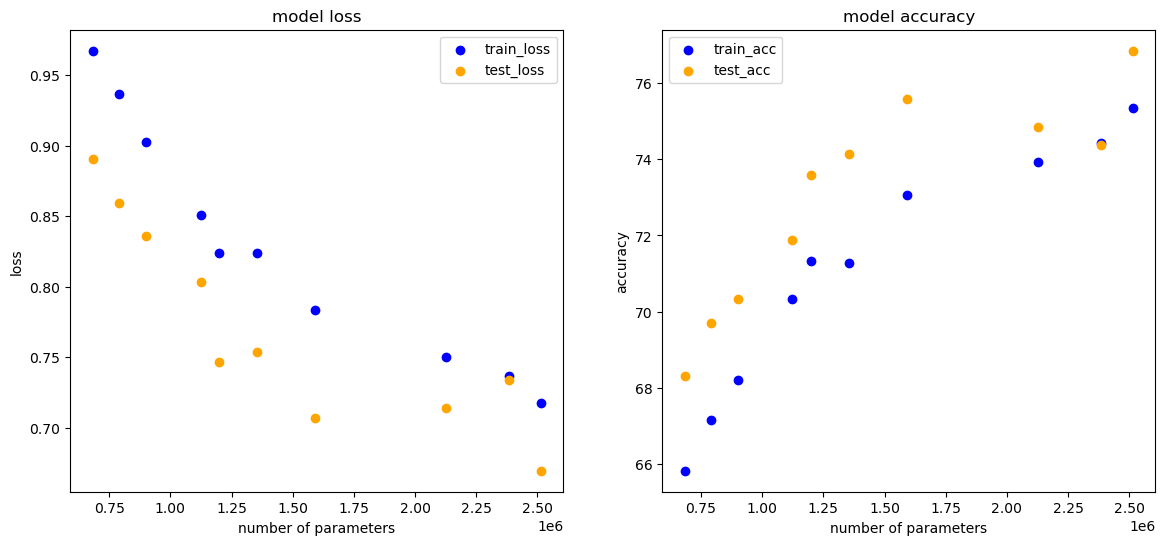

In [7]:
plt.figure(figsize=(14, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.scatter(num_params, all_train_losses, label='train_loss', color='blue')
plt.scatter(num_params, all_test_losses, label='test_loss', color='orange')
plt.xlabel('number of parameters')
plt.ylabel('loss')
plt.title('model loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.scatter(num_params, all_train_accs, label='train_acc', color='blue')
plt.scatter(num_params, all_test_accs, label='test_acc', color='orange')
plt.xlabel('number of parameters')
plt.ylabel('accuracy')
plt.title('model accuracy')
plt.legend()

plt.show()